<a href="https://colab.research.google.com/github/Rdcornejov/Data-mining-Tools/blob/main/Semana5_2_Ejercicio_teoria_CursoIngenieriaCaracteristicas_Qu%C3%A9_es_la_ingenier%C3%ADa_de_caracter%C3%ADsticas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'fe-course-data:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F933090%2F1828856%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240915%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240915T235554Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D9145ea06799e082ec8f5f7a4bbae027cf0121395bbaf5df7f0071b762a2b9a0c087d74228ed800a9a600d50b4f503e4a58d152f975333a46b256536cc2ba2a36d467b99389cb4f464d31f7fb7df947f415256f3ebe48130de07c8160aab9b3b3bcac792eebb927de34ef3278375c95867d3f0e829131a65c873103cf7ec0ac2a3730387d1cca8695bab28708e7be603fdb50f01ded7d659ba7ec900c669e71bcc59385dcee48aa140946647899b7eca4083c466e0b259258deaf145dccbd937de1f37cf1e4dc22eac46d91da01d4109584de88d920e41815c7c4ee87eae34c5f78529ddaa73b5687c9fb3907bcea24e6c02c39dcf6828d6fce46d372d9e8c0f8'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 27023163 bytes downloaded
Downloaded and uncompressed: fe-course-data
Data source import complete.


In [6]:
!pip install learntools

**This notebook is an exercise in the [Feature Engineering](https://www.kaggle.com/learn/feature-engineering) course.  You can reference the tutorial at [this link](https://www.kaggle.com/ryanholbrook/mutual-information).**

---


# Introduction #

In this exercise you'll identify an initial set of features in the [*Ames*](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data) dataset to develop using mutual information scores and interaction plots.

Run this cell to set everything up!

In [12]:

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.feature_selection import mutual_info_regression

# Set Matplotlib defaults
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)


# Load data
df = pd.read_csv("../input/fe-course-data/ames.csv")


# Utility functions from Tutorial
def make_mi_scores(X, y):
    X = X.copy()
    for colname in X.select_dtypes(["object", "category"]):
        X[colname], _ = X[colname].factorize()
    # All discrete features should now have integer dtypes
    discrete_features = [pd.api.types.is_integer_dtype(t) for t in X.dtypes]
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features, random_state=0)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores


def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")

<ipython-input-12-d3ffb8057f3c>:8: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-whitegrid")


In [13]:
df.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YearSold,SaleType,SaleCondition,SalePrice
0,One_Story_1946_and_Newer_All_Styles,Residential_Low_Density,141.0,31770.0,Pave,No_Alley_Access,Slightly_Irregular,Lvl,AllPub,Corner,...,0.0,No_Pool,No_Fence,NaN,0.0,5,2010,WD,Normal,215000
1,One_Story_1946_and_Newer_All_Styles,Residential_High_Density,80.0,11622.0,Pave,No_Alley_Access,Regular,Lvl,AllPub,Inside,...,0.0,No_Pool,Minimum_Privacy,NaN,0.0,6,2010,WD,Normal,105000
2,One_Story_1946_and_Newer_All_Styles,Residential_Low_Density,81.0,14267.0,Pave,No_Alley_Access,Slightly_Irregular,Lvl,AllPub,Corner,...,0.0,No_Pool,No_Fence,Gar2,12500.0,6,2010,WD,Normal,172000
3,One_Story_1946_and_Newer_All_Styles,Residential_Low_Density,93.0,11160.0,Pave,No_Alley_Access,Regular,Lvl,AllPub,Corner,...,0.0,No_Pool,No_Fence,NaN,0.0,4,2010,WD,Normal,244000
4,Two_Story_1946_and_Newer,Residential_Low_Density,74.0,13830.0,Pave,No_Alley_Access,Slightly_Irregular,Lvl,AllPub,Inside,...,0.0,No_Pool,Minimum_Privacy,NaN,0.0,3,2010,WD,Normal,189900


-------------------------------------------------------------------------------

To start, let's review the meaning of mutual information by looking at a few features from the *Ames* dataset.

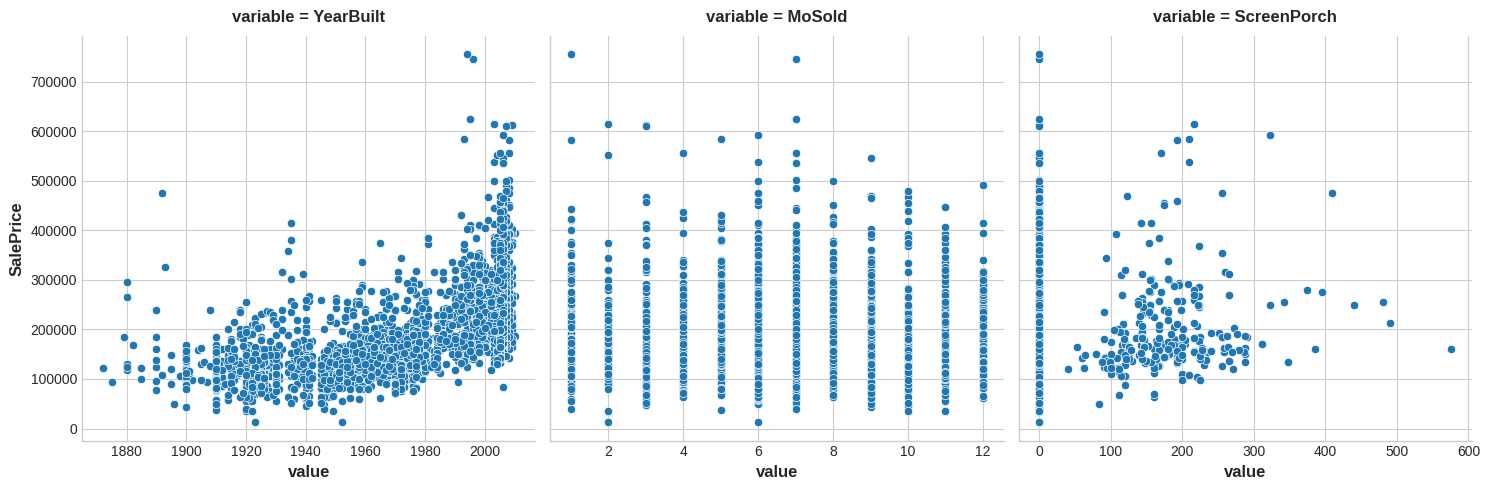

In [14]:
features = ["YearBuilt", "MoSold", "ScreenPorch"]
sns.relplot(
    x="value", y="SalePrice", col="variable", data=df.melt(id_vars="SalePrice", value_vars=features), facet_kws=dict(sharex=False),
);

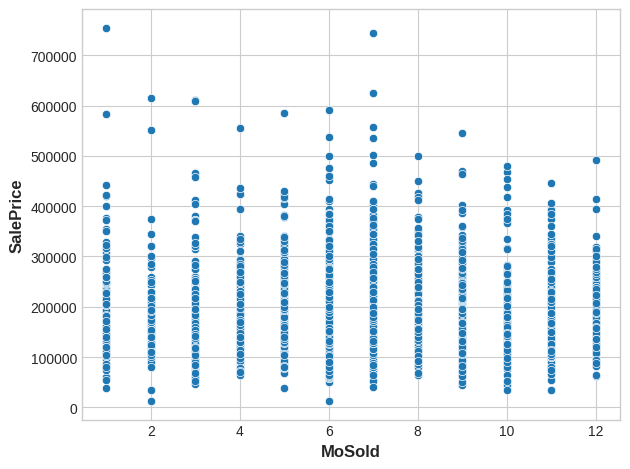

In [15]:
sns.scatterplot(x="MoSold", y="SalePrice", data=df)
plt.show()

# 1) Understand Mutual Information

Based on the plots, which feature do you think would have the highest mutual information with `SalePrice`?

In [ ]:
# View the solution (Run this cell to receive credit!)
df["YearBuilt"]

Correcto:

Según los gráficos, YearBuilt debería tener la puntuación MI más alta, ya que conocer el año tiende a limitar SalePrice a un rango más pequeño de valores posibles. Sin embargo, este no suele ser el caso de MoSold. Por último, dado que ScreenPorch suele tener un solo valor, 0, en promedio no le dirá mucho sobre SalePrice (aunque sí más que MoSold).

-------------------------------------------------------------------------------

The *Ames* dataset has seventy-eight features -- a lot to work with all at once! Fortunately, you can identify the features with the most potential.

Use the `make_mi_scores` function (introduced in the tutorial) to compute mutual information scores for the *Ames* features:


In [16]:
X = df.copy()
y = X.pop('SalePrice')

mi_scores = make_mi_scores(X, y)

Now examine the scores using the functions in this cell. Look especially at top and bottom ranks.

OverallQual     0.581262
Neighborhood    0.569813
GrLivArea       0.496909
YearBuilt       0.437939
GarageArea      0.415014
TotalBsmtSF     0.390280
GarageCars      0.381467
FirstFlrSF      0.368825
BsmtQual        0.364779
KitchenQual     0.326194
ExterQual       0.322390
YearRemodAdd    0.315402
MSSubClass      0.287131
GarageFinish    0.265440
FullBath        0.251693
Foundation      0.236115
LotFrontage     0.233334
GarageType      0.226117
FireplaceQu     0.221955
SecondFlrSF     0.200658
Name: MI Scores, dtype: float64


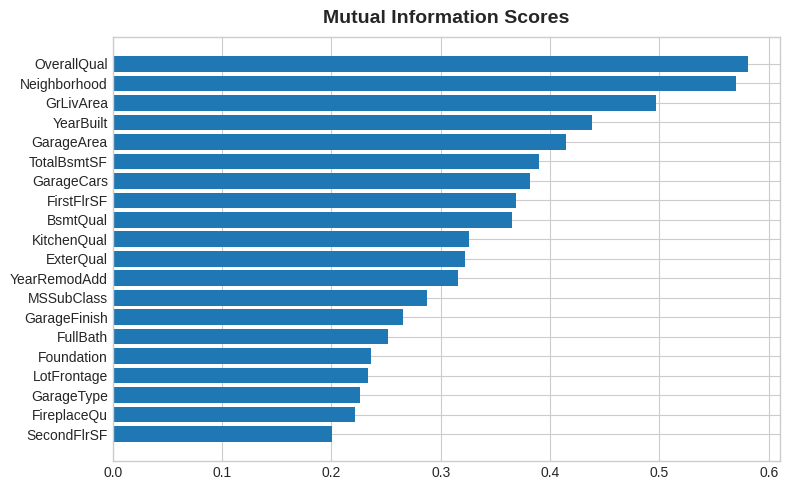

In [17]:
print(mi_scores.head(20))
# print(mi_scores.tail(20))  # uncomment to see bottom 20

plt.figure(dpi=100, figsize=(8, 5))
plot_mi_scores(mi_scores.head(20))
# plot_mi_scores(mi_scores.tail(20))  # uncomment to see bottom 20

# 2) Examine MI Scores

Do the scores seem reasonable? Do the high scoring features represent things you'd think most people would value in a home? Do you notice any themes in what they describe?

In [ ]:
# View the solution (Run this cell to receive credit!)

Correcto:

Algunos temas comunes entre la mayoría de estas características son:

Ubicación: vecindario
Tamaño: todas las características de área y pies cuadrados, y recuentos como baño completo y garaje
Calidad: todas las características de calidad
Año: año de construcción y año de remodelación
Tipos: descripciones de características y estilos como cimientos y tipo de garaje
Estas son todas las clases de características que verá comúnmente en los listados de bienes raíces (como en Zillow). Es bueno que nuestra métrica de información mutua las haya calificado alto. Por otro lado, las características con la clasificación más baja parecen representar principalmente cosas que son raras o excepcionales de alguna manera y, por lo tanto, no serían relevantes para el comprador de vivienda promedio.

-------------------------------------------------------------------------------

In this step you'll investigate possible interaction effects for the `BldgType` feature. This feature describes the broad structure of the dwelling in five categories:

> Bldg Type (Nominal): Type of dwelling
>
>       1Fam	Single-family Detached
>       2FmCon	Two-family Conversion; originally built as one-family dwelling
>       Duplx	Duplex
>       TwnhsE	Townhouse End Unit
>       TwnhsI	Townhouse Inside Unit

The `BldgType` feature didn't get a very high MI score. A plot confirms that the categories in `BldgType` don't do a good job of distinguishing values in `SalePrice` (the distributions look fairly similar, in other words):

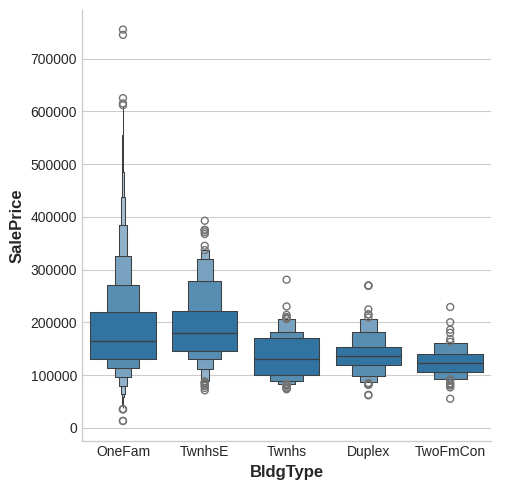

In [18]:
sns.catplot(x="BldgType", y="SalePrice", data=df, kind="boxen");

Still, the type of a dwelling seems like it should be important information. Investigate whether `BldgType` produces a significant interaction with either of the following:

```
GrLivArea  # Área habitable sobre el nivel del suelo
MoSold     # Mes de venta
```

Run the following cell twice, the first time with `feature = "GrLivArea"` and the next time with `feature="MoSold"`:

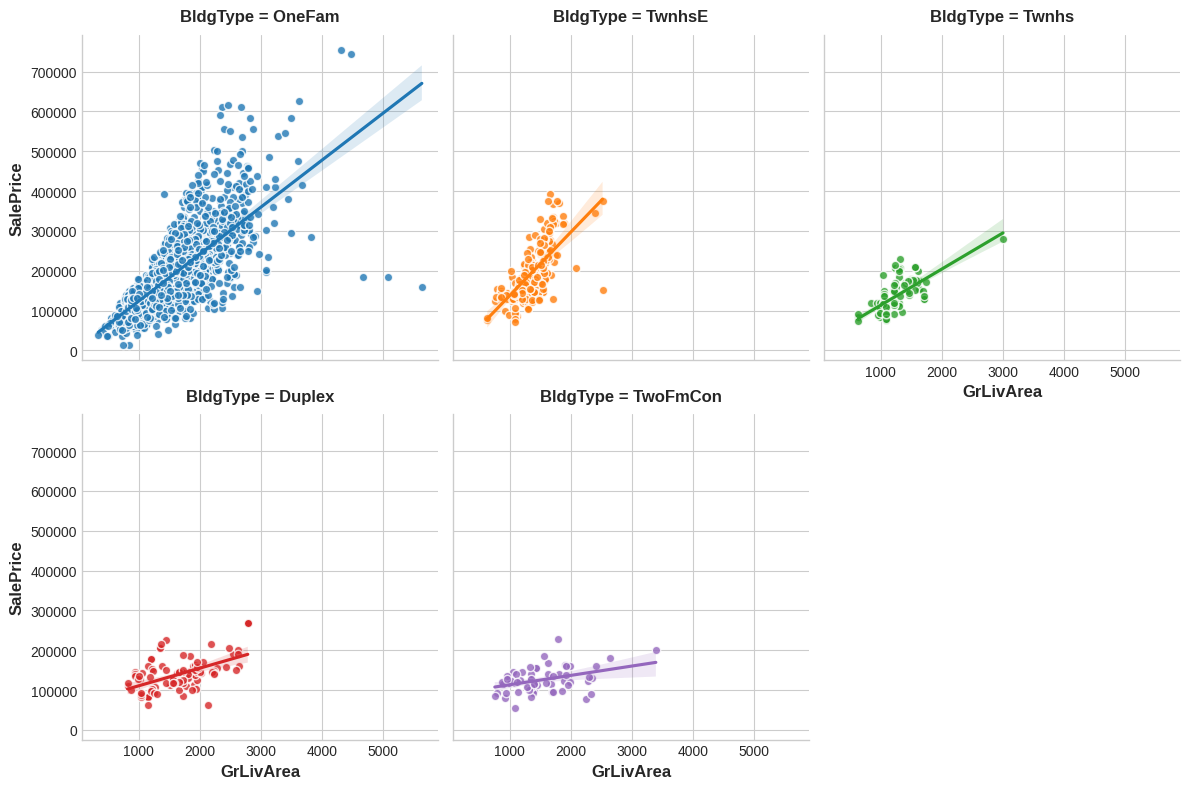

In [19]:
# YOUR CODE HERE:
feature = "GrLivArea"

sns.lmplot(
    x=feature, y="SalePrice", hue="BldgType", col="BldgType",
    data=df, scatter_kws={"edgecolor": 'w'}, col_wrap=3, height=4,
);

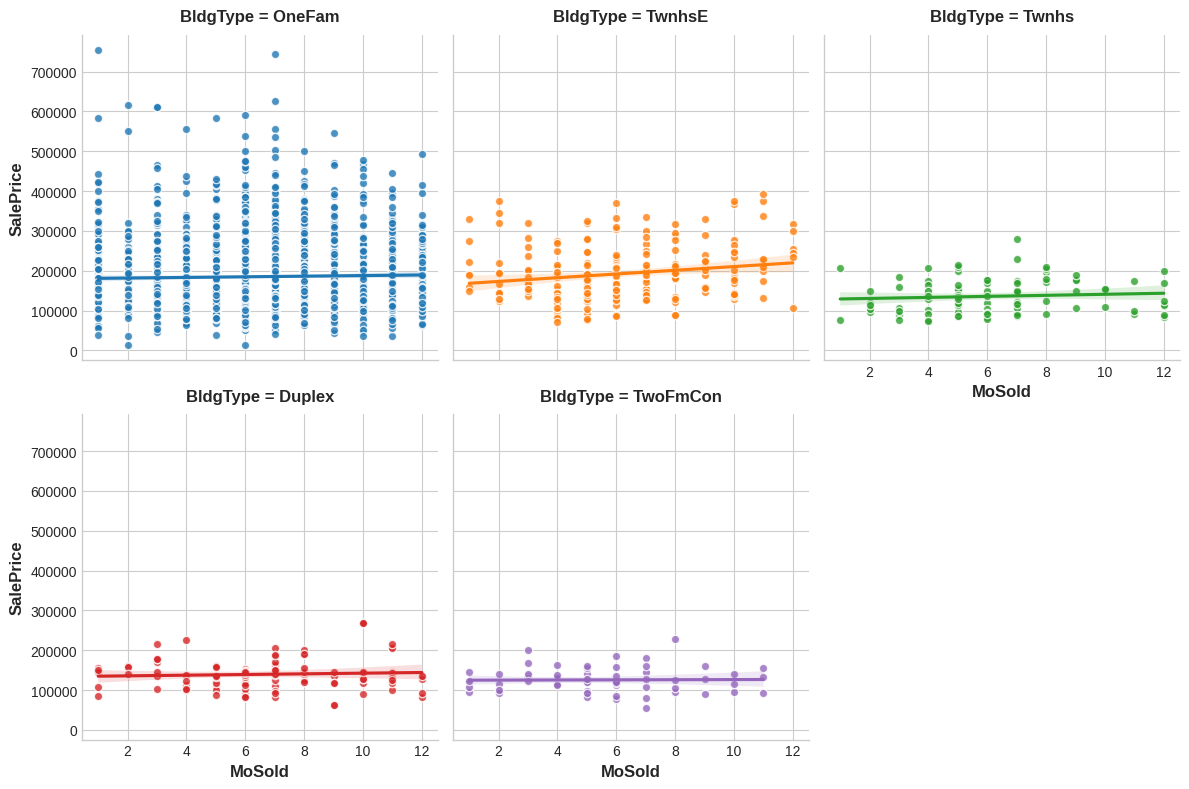

In [20]:
feature = "MoSold"

sns.lmplot(
    x=feature, y="SalePrice", hue="BldgType", col="BldgType",
    data=df, scatter_kws={"edgecolor": 'w'}, col_wrap=3, height=4,
);

The trend lines being significantly different from one category to the next indicates an interaction effect.

# 3) Discover Interactions

From the plots, does `BldgType` seem to exhibit an interaction effect with either `GrLivArea` or `MoSold`?

In [ ]:
# View the solution (Run this cell to receive credit!)

q_3.check()


Cirrecti
Las líneas de tendencia dentro de cada categoría de BldgType son claramente muy diferentes, lo que indica una interacción entre estas características. Dado que conocer BldgType nos dice más sobre cómo se relaciona GrLivArea con SalePrice, deberíamos considerar incluir BldgType en nuestro conjunto de características.

Sin embargo, las líneas de tendencia para MoSold son casi todas iguales. Esta característica no se ha vuelto más informativa para conocer BldgType.

# A First Set of Development Features #

Let's take a moment to make a list of features we might focus on. In the exercise in Lesson 3, you'll start to build up a more informative feature set through combinations of the original features you identified as having high potential.

You found that the ten features with the highest MI scores were:

In [21]:
mi_scores.head(10)

,MI Scores
OverallQual,0.581262
Neighborhood,0.569813
GrLivArea,0.496909
YearBuilt,0.437939
GarageArea,0.415014
TotalBsmtSF,0.390280
GarageCars,0.381467
FirstFlrSF,0.368825
BsmtQual,0.364779
KitchenQual,0.326194


Do you recognize the themes here? Location, size, and quality. You needn't restrict development to only these top features, but you do now have a good place to start. Combining these top features with other related features, especially those you've identified as creating interactions, is a good strategy for coming up with a highly informative set of features to train your model on.

# Keep Going #

[**Start creating features**](https://www.kaggle.com/ryanholbrook/creating-features) and learn what kinds of transformations different models are most likely to benefit from.

---




*Have questions or comments? Visit the [course discussion forum](https://www.kaggle.com/learn/feature-engineering/discussion) to chat with other learners.*